In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My\ Drive

/content/drive/My Drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
bs = 32

In [5]:
path_img = Path('fast-data')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Compact,Compact,Compact,Compact,Compact
Path: fast-data;

Valid: LabelList (307 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: fast-data;

Test: None

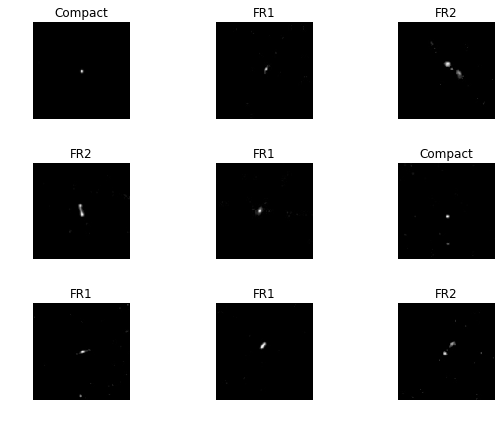

In [6]:
data.show_batch(rows=3, figsize=(8,6))

In [0]:
print(data.classes)
len(data.classes), data.c

['Bent', 'Compact', 'FR1', 'FR2']


(4, 4)

In [7]:
learn = create_cnn(data, models.densenet201, metrics=[accuracy, FBeta()])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:15<00:00, 5336280.09it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.61E-03
Min loss divided by 10: 6.92E-03


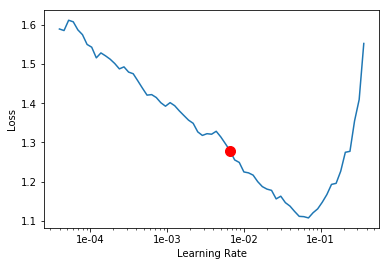

In [8]:
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.115192,0.496558,0.801303,0.809879,01:05


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


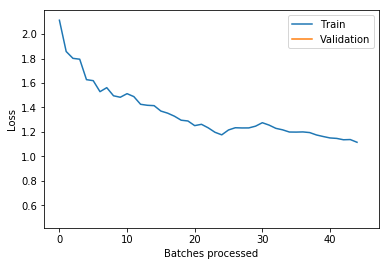

In [9]:
#train the model
learn.fit_one_cycle(1, max_lr=slice(6e-3,4e-2))
learn.save('stage1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-05
Min loss divided by 10: 5.25E-05


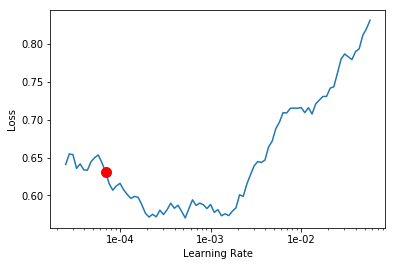

In [10]:
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.621135,0.311954,0.902280,0.896296,00:26
1,0.502064,0.245798,0.928339,0.929211,00:26
2,0.446617,0.215802,0.934853,0.938184,00:27


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


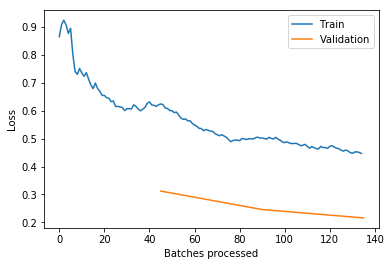

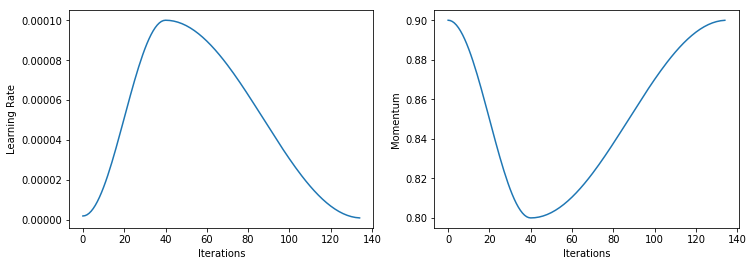

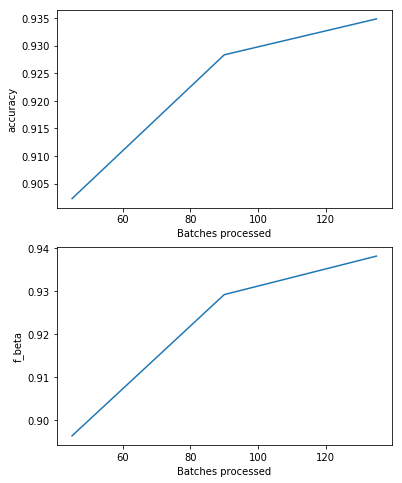

In [11]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-4), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))
learn.save('201na-stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.410992,0.233991,0.918567,0.917642,00:26
1,0.373742,0.214827,0.921824,0.919977,00:26
2,0.321308,0.146783,0.947883,0.949107,00:26
3,0.332176,0.132514,0.947883,0.949718,00:27
4,0.288802,0.107793,0.964169,0.966046,00:27
5,0.246438,0.103845,0.960912,0.960478,00:27
6,0.229895,0.094725,0.964169,0.966021,00:27
7,0.217863,0.092855,0.970684,0.972306,00:27
8,0.212412,0.092630,0.967427,0.968542,00:27
9,0.211387,0.090615,0.977199,0.978486,00:27


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


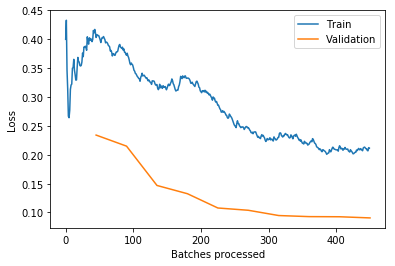

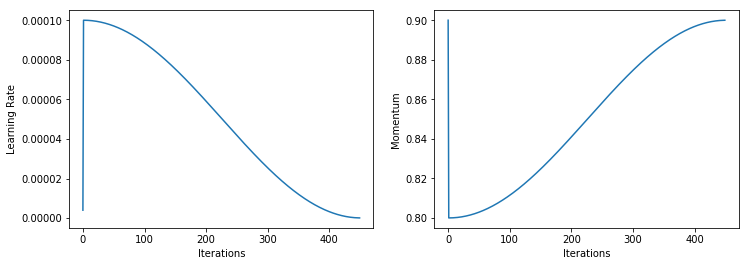

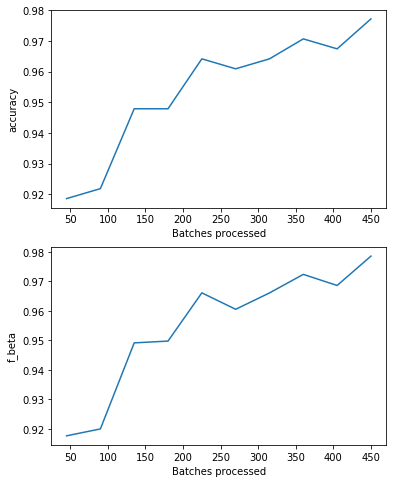

In [12]:
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-5, 1e-4), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('d201stage-3-final')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [0]:
#learn.save('d201-noaug')

In [0]:
#interpret the training reults
learn.load('d201stage-3-final')
interp = ClassificationInterpretation.from_learner(learn)

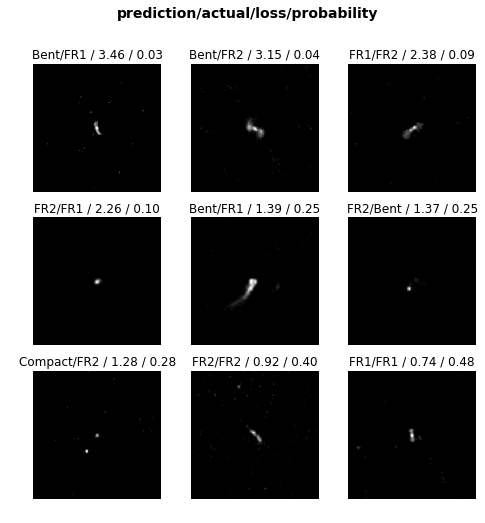

In [15]:
interp.plot_top_losses(9, figsize=(8,8))

In [16]:
interp.most_confused(min_val=2)

[('FR1', 'Bent', 2)]

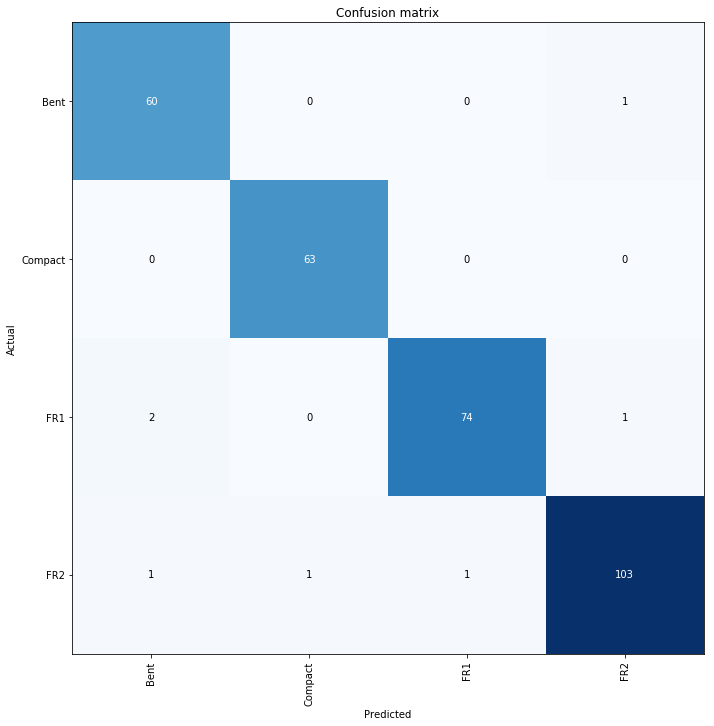

In [17]:
interp.plot_confusion_matrix(figsize=(10,10))

In [0]:
learn.export('d201stage-3-final.pkl')

In [19]:
#Testing the model

path_img = Path('fast-data')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Compact,Compact,Compact,Compact,Compact
Path: fast-data;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: fast-data;

Test: None

In [0]:
#Get the architecture and reload the model weights
learn = cnn_learner(data, models.densenet201, metrics=[accuracy, FBeta()])

In [0]:
learn = learn.load('d201stage-3-final')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

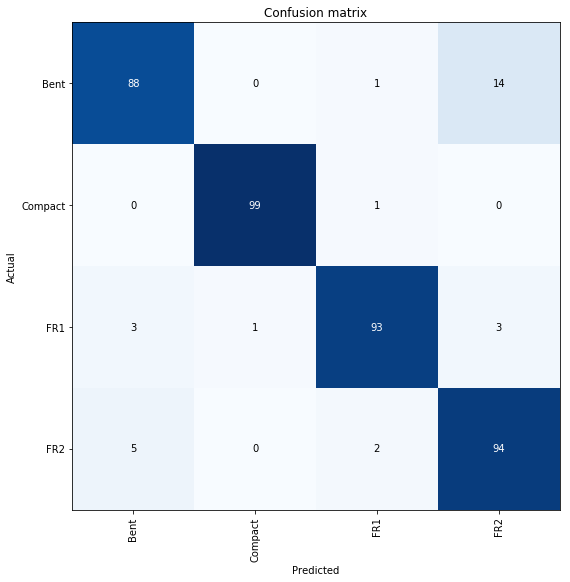

In [23]:
interp.plot_confusion_matrix(figsize=(8,8))

In [24]:
import glob

image_list = glob.glob('fast-data/test/*/*')

Bent = 0
Pred_Bent=0
Compact=0
Pred_Compact=0
FRI=0
Pred_FRI=0
FRII=0
Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
    elif rg_class == 'FR1':
        FRI += 1
        if pred_class == 'FR1':
            Pred_FRI += 1
    elif rg_class == 'FR2':
        FRII += 1
        if pred_class == 'FR2':
            Pred_FRII += 1
            
    
print('Bent accuracy: ' + str(Pred_Bent) + '/' + str(Bent))
print('Compact accuracy: ' + str(Pred_Compact) + '/' + str(Compact))
print('FR1 accuracy: ' + str(Pred_FRI) + '/' + str(FRI) )
print('FR2 accuracy: ' + str(Pred_FRII) + '/' + str(FRII) )

Bent accuracy: 88/103
Compact accuracy: 99/100
FR1 accuracy: 93/100
FR2 accuracy: 94/101


In [25]:
interp.most_confused(min_val=2)

[('Bent', 'FR2', 14),
 ('FR2', 'Bent', 5),
 ('FR1', 'Bent', 3),
 ('FR1', 'FR2', 3),
 ('FR2', 'FR1', 2)]